In [1]:
import iris
import numpy as np
from iris.coords import DimCoord
from iris.coord_systems import TransverseMercator,GeogCS
from iris.cube import Cube
from cf_units import Unit
import cf_units
import os
import glob
from pyproj import Proj, transform
import sys
import warnings
import multiprocessing as mp
import cartopy.crs as ccrs

warnings.filterwarnings("ignore")

ems_hourly = ['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
ems_30mins = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']
yrs_range = '1980_2001'

In [2]:
##########################################################################################
#########################################################################################
# Define variables and set up environment
##########################################################################################
##########################################################################################
root_fp = "/nfs/a319/gy17m2a/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'PhD/Scripts/DataProcessing/Regridding')
from Regridding_functions import *
# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

# Load UKCP18 12km model data to use in regriddding
file_model_12km=f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/{yrs_range}/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
cube_12km=iris.load_cube(file_model_12km)

file_model_2_2km ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_2km =iris.load_cube(file_model_2_2km)

# remove ensemble member dimension
cube_2km = cube_2km[0,:,:,:]
cube_12km = cube_12km[0,:,:,:]

In [3]:
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
cube_12km_trimmed_to_leeds =  trim_to_bbox_of_region_obs(cube_12km, leeds_at_centre_gdf)

In [4]:
yrs_range = '1980_2001'
# ems_hourly = ['04', '06', '07', '08', '09', '10', ]

### Trim so the same size

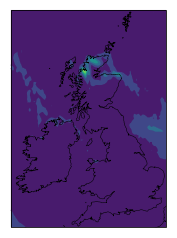

In [5]:
cube_2km = trim_to_bbox_of_region_regriddedobs(cube_2km, gb_gdf)
cube_12km = trim_to_bbox_of_region_obs(cube_12km, gb_gdf)

iplt.contourf(cube_12km[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Inspect coordinates

In [ ]:
### 2km cube has grid_latitude and grid_longitude as 1D dimension coordinates (rotated geodesic)
### 2km cube has projection_y_coordinate and projection_x_coordinate as 1D dimension coordinates (BNG)

In [54]:
# cube_2km_test = cube_2km[0,1:5,:,:]
# cube_12km_test = cube_12km[0,1:5,:,:]
# iris.save(cube_12km_test,"mytest2km.nc")
# iris.save(cube_2km_test,"myest12km.nc")

In [ ]:
# print(cube_2km.coord('grid_latitude').shape)
# print(cube_2km.coord('grid_longitude').shape)
# print(cube_12km.coord('projection_y_coordinate').shape)
# print(cube_12km.coord('projection_x_coordinate').shape)

In [ ]:
### 2km cube has latitude and longitude as 2D dimension coordinates (rotated geodesic)
### 12km cube has grid_latitude and grid_longitude as 2D dimension coordinates (BNG)

In [ ]:
# print(cube_2km.coord('latitude').shape)
# print(cube_2km.coord('longitude').shape)
# print(cube_12km.coord('grid_latitude').shape)
# print(cube_12km.coord('grid_longitude').shape)

In [ ]:
### But are the grid_latitude and grid_longitude coordinates the same?
### Don't think so
### 2km is in rotated pole
### But 12km is in WGS84 still

In [ ]:
# cube_12km.coord('grid_latitude').coord_system

# print(cube_2km.coord('grid_longitude').coord_system)
# print(cube_2km.coord('longitude').coord_system)

# print(cube_12km.coord('projection_y_coordinate').coord_system)
# print(cube_12km.coord('grid_longitude').coord_system)

## Transform cube 12km to WGS84

In [9]:
# this is the crs that we want to transform to
source_crs_12km = ccrs.OSGB(approx=False)
source_crs_2km = ccrs.RotatedGeodetic(pole_latitude=37.5,
                                        pole_longitude=177.5,
                                        central_rotated_longitude=0)

# these are the crs we are transforming from
target_crs = ccrs.Geodetic()

In [12]:
def convert_to_wgs84(source_crs, cube, x_coord_name, y_coord_name):
    # Extract the 2D meshgrid of X (eastings) and Y (northings) coordinates from the cube
    x = cube.coord(x_coord_name).points
    y = cube.coord(y_coord_name).points
    xx, yy = np.meshgrid(x, y)

    # Also get time for the new cube
    time_coord = cube.coord('time')

    # Use transform_points to project your coordinates
    transformed_points = target_crs.transform_points(source_crs, xx.flatten(), yy.flatten())

    # transformed_points now has a shape (n*m, 3), where the last dimension contains (lon, lat, z)
    # Reshape the array back to your original grid shape and separate the components
    lons, lats = transformed_points[..., 0].reshape(xx.shape), transformed_points[..., 1].reshape(yy.shape)

    # Now, you should create a new cube with these lons and lats as coordinates.
    # Note: This step requires careful handling to ensure the new cube's data aligns correctly with the transformed coordinates.
    # You might need to create new latitude and longitude DimCoords, ensuring they have bounds set if performing area-weighted regridding later.

    # Here's a simplified way to create a new cube with the transformed coordinates,
    # assuming your original data is 2-dimensional and compatible with the new grid.
    new_cube_data = cube.data  # This might require adjustment if the data needs to be interpolated onto the new grid.
    latitude_coord = iris.coords.DimCoord(lats[:, 0], standard_name='latitude', units='degrees')
    longitude_coord = iris.coords.DimCoord(lons[0, :], standard_name='longitude', units='degrees')

    # Guess bounds
    latitude_coord.guess_bounds()
    longitude_coord.guess_bounds()

    cube_wgs84 = iris.cube.Cube(new_cube_data,
                              dim_coords_and_dims=[(time_coord, 0), (latitude_coord, 1), (longitude_coord, 2)],
                              standard_name=cube.standard_name,
                              units=cube.units)
    
    return cube_wgs84

    
    

In [18]:
for em in ['01']:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/{em}/{yrs_range}/")
    output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_wgs84/{em}/{yrs_range}/"
    if not os.path.isdir(output_fp):
        os.makedirs(output_fp)
    for filename in glob.glob("*"):     
            if filename[47:49] in ['06', '07', '08']:
                if os.path.isfile(output_fp +  f"wgs84_{filename}"):
                    print("already exist")
                else:
                    print(filename)
                    cube = iris.load(filename)[0]
                    # transform to wgs84
                    transformed_cube_2km = convert_to_wgs84 (source_crs_2km, cube_2km, "grid_longitude", "grid_latitude")
                    # Save 
                    iris.save(reg_cube_nn, output_fp +  f"wgs84_{filename}")     

01


In [14]:
transformed_cube_12km = convert_to_wgs84 (source_crs_12km, cube_12km,'projection_x_coordinate', 'projection_y_coordinate')
transformed_cube_2km = convert_to_wgs84 (source_crs_2km, cube_2km, "grid_longitude", "grid_latitude")

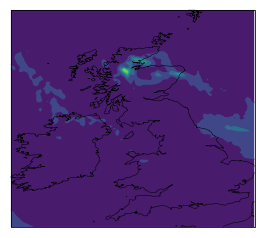

In [13]:
iplt.contourf(cube_12km_wgs84[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

## Transform cube 2.2km to WGS84

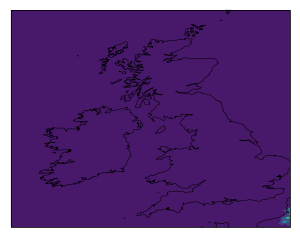

In [15]:
iplt.contourf(transformed_cube_2km[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [24]:
cube_rotated_regridded = cube_2km_wgs84.regrid(cube_12km_wgs84, iris.analysis.AreaWeighted()) 

(array([679.,  26.,   9.,   1.,   2.,   1.,   1.,   0.,   0.,   1.]),
 array([0.       , 0.7179728, 1.4359456, 2.1539185, 2.8718913, 3.589864 ,
        4.307837 , 5.02581  , 5.7437825, 6.4617553, 7.179728 ],
       dtype=float32),
 <a list of 10 Patch objects>)

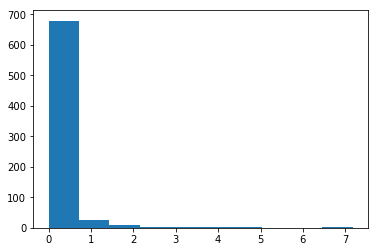

In [39]:
plt.hist(cube_rotated_regridded[:,1,1].data.data)
# cube_rotated_regridded[:,1,1].data.data.shape#[:,1,1]

## Regrid hourly UKCP18 data to 12km - DONE

In [6]:
for em in ['05']:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/{em}/{yrs_range}/")
    output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_regridded_12km/{em}/NearestNeighbour/{yrs_range}/"
    if not os.path.isdir(output_fp):
        os.makedirs(output_fp)
    for filename in glob.glob("*"):     
            if filename[47:49] in ['06', '07', '08']:
                if os.path.isfile(output_fp +  f"rg_{filename}_aw"):
                    print("already exist")
                else:
                    print(filename)
                    cube = iris.load(filename)[0]
                    # Linear interpolation
                    #reg_cube_lin =cube.regrid(cube_model,iris.analysis.Linear())      
                    # Nearest neighbour
                    reg_cube_nn =cube.regrid(cube_12km,iris.analysis.AreaWeighted())   
                    # Save 
                    iris.save(reg_cube_nn, output_fp +  f"rg_{filename}_aw")     

05
pr_rcp85_land-cpm_uk_2.2km_05_1hr_20160801-20160830.nc


ValueError: The horizontal grid coordinates of both the source and grid cubes must have the same coordinate system.

## Regrid 30 mins UKCP18 data to 12km - DONE
For this need to use version of the regridding cube which is trimmed to the leeds-at-centre region, as the 30 mins data is already clipped to this extent

In [12]:
ems_30mins =  ['bc005',  'bc006',  'bc007', 'bc009',  'bc010', 
       'bc011', 'bc013',  'bc015',  'bc016',  'bc017', 'bc018', 'bc012']

In [14]:
for em in ems_30mins:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km/{em}/2002_2020/")
    output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_regridded_12km/{em}/NearestNeighbour/2002_2020/"
    if not os.path.isdir(output_fp):
        os.makedirs(output_fp)
    for filename in np.sort(glob.glob("*")):   
        print(filename)
        if not os.path.isfile(output_fp +  f"rg_{filename}"):
            print("creating")
            # print(filename)
            cube = iris.load(filename)[0]
            # Linear interpolation
            #reg_cube_lin =cube.regrid(cube_model,iris.analysis.Linear())      
            # Nearest neighbour
            try:
                reg_cube_nn =cube.regrid(cube_12km_trimmed_to_leeds,iris.analysis.Nearest())   
            except:
                print("Didnt work")
                pass
            # print(reg_cube_nn.shape)
            # Save 
            iris.save(reg_cube_nn, output_fp +  f"rg_{filename}") 
        else:
            print("already exists")

bc005
bc005a.pr200006.nc
already exists
bc005a.pr200007.nc
already exists
bc005a.pr200008.nc
already exists
bc005a.pr200106.nc
already exists
bc005a.pr200107.nc
already exists
bc005a.pr200108.nc
already exists
bc005a.pr200206.nc
already exists
bc005a.pr200207.nc
already exists
bc005a.pr200208.nc
already exists
bc005a.pr200306.nc
already exists
bc005a.pr200307.nc
already exists
bc005a.pr200308.nc
already exists
bc005a.pr200406.nc
already exists
bc005a.pr200407.nc
already exists
bc005a.pr200408.nc
already exists
bc005a.pr200506.nc
already exists
bc005a.pr200507.nc
already exists
bc005a.pr200508.nc
already exists
bc005a.pr200606.nc
already exists
bc005a.pr200607.nc
already exists
bc005a.pr200608.nc
already exists
bc005a.pr200706.nc
already exists
bc005a.pr200707.nc
already exists
bc005a.pr200708.nc
already exists
bc005a.pr200806.nc
already exists
bc005a.pr200807.nc
already exists
bc005a.pr200808.nc
already exists
bc005a.pr200906.nc
already exists
bc005a.pr200907.nc
already exists
bc005a.p

already exists
bc010a.pr200708.nc
already exists
bc010a.pr200806.nc
already exists
bc010a.pr200807.nc
already exists
bc010a.pr200808.nc
already exists
bc010a.pr200906.nc
already exists
bc010a.pr200907.nc
already exists
bc010a.pr200908.nc
already exists
bc010a.pr201006.nc
already exists
bc010a.pr201007.nc
already exists
bc010a.pr201008.nc
already exists
bc010a.pr201106.nc
already exists
bc010a.pr201107.nc
already exists
bc010a.pr201108.nc
already exists
bc010a.pr201206.nc
already exists
bc010a.pr201207.nc
already exists
bc010a.pr201208.nc
already exists
bc010a.pr201306.nc
already exists
bc010a.pr201307.nc
already exists
bc010a.pr201308.nc
already exists
bc010a.pr201406.nc
already exists
bc010a.pr201407.nc
already exists
bc010a.pr201408.nc
already exists
bc010a.pr201506.nc
already exists
bc010a.pr201507.nc
already exists
bc010a.pr201508.nc
already exists
bc010a.pr201606.nc
already exists
bc010a.pr201607.nc
already exists
bc010a.pr201608.nc
already exists
bc010a.pr201706.nc
already exists

already exists
bc016a.pr201407.nc
already exists
bc016a.pr201408.nc
already exists
bc016a.pr201506.nc
already exists
bc016a.pr201507.nc
already exists
bc016a.pr201508.nc
already exists
bc016a.pr201606.nc
already exists
bc016a.pr201607.nc
already exists
bc016a.pr201608.nc
already exists
bc016a.pr201706.nc
already exists
bc016a.pr201707.nc
already exists
bc016a.pr201708.nc
already exists
bc016a.pr201806.nc
already exists
bc016a.pr201807.nc
already exists
bc016a.pr201808.nc
already exists
bc016a.pr201906.nc
already exists
bc016a.pr201907.nc
already exists
bc016a.pr201908.nc
already exists
bc016a.pr202006.nc
already exists
bc016a.pr202007.nc
already exists
bc016a.pr202008.nc
already exists
bc017
bc017a.pr200006.nc
already exists
bc017a.pr200007.nc
already exists
bc017a.pr200008.nc
already exists
bc017a.pr200106.nc
already exists
bc017a.pr200107.nc
already exists
bc017a.pr200108.nc
already exists
bc017a.pr200206.nc
already exists
bc017a.pr200207.nc
already exists
bc017a.pr200208.nc
already 

## Regrid NIMROD - DONE

In [5]:
for year in range(2012,2013):
    print(year)
    # Change directory to be for correct year
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/{year}")
    # Define filepaths to save files to
    output_dir_12km = f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/"
    output_dir_2_2km = f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/"
    # Create these directories if they don't exist already
    if not os.path.isdir(output_dir_12km):
        os.makedirs(output_dir_12km)
    if not os.path.isdir(output_dir_2_2km):
        os.makedirs(output_dir_2_2km)
    # Loop through all the diles in the 1km folder    
    for filename in sorted(glob.glob("*")):
        if filename != 'metoffice-c-band-rain-radar_uk_20090728_30mins.nc':
            print(filename)
            # Create version of filename specifying it is regridded
            filename_to_save_to = f"rg_{filename}"

            # Check if this regridded file exists, and if not create it
            # Don't want to load the cube twice unnecessarily, so if we load it for 12km, then make a flag to tell us it's
            # already loaded and then use this for 2.2km

            # 12km regridding
            if os.path.isfile(output_dir_12km + filename_to_save_to):
                print("File already exists")
            if not os.path.isfile(output_dir_12km + filename_to_save_to):
                print('Making file 12km')
                cube = iris.load(filename)[0]
                loaded_cube=True
                # Nearest neighbour
                reg_cube_nn =cube.regrid(cube_12km,iris.analysis.Nearest())    
                # Save 
                iris.save(reg_cube_nn, output_dir_12km + filename_to_save_to)

            # 2.2km regridding
            if os.path.isfile(output_dir_2_2km + filename_to_save_to):
                print("File already exists")
            if not os.path.isfile(output_dir_2_2km + filename_to_save_to):
                print('Making 2.2km file')
                if loaded_cube == False:
                    cube = iris.load(filename)[0]
                # Nearest neighbour
                reg_cube_nn =cube.regrid(cube_model_2_2km,iris.analysis.Nearest())    
                print("Regridded")
                # Save 
                iris.save(reg_cube_nn, output_dir_2_2km + filename_to_save_to)    

            loaded_cube=False


2012
metoffice-c-band-rain-radar_uk_20120601_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120602_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120603_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120604_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120605_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120606_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120607_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120608_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120609_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120610_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120611_30min

Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120827_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120828_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120829_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120830_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120831_30mins.nc
Making file 12km
Making 2.2km file
Regridded


## Regrid CEH-GEAR

In [31]:
# os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/OriginalFormat/")
# filenames =[ ]
# for filename in glob.glob("*"):
#     filenames.append(filename)
# len(filenames)

In [ ]:
os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/OriginalFormat/")
for filename in glob.glob("*")
    print(filename)
    cube = iris.load(filename)[0]
    
    # Filename to save reformatted cube to
    filename_to_save_to_reformat = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_{filename}"
    # Filename to save 2.2km regridded cube to -- linear
    filename_to_save_to_lin_2_2km = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/LinearRegridding/rg_{filename}"
    # Filename to save 2.2km regridded cube to -- nearest neighbour
    filename_to_save_to_nn_2_2km = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/NearestNeighbour/rg_{filename}"
      # Filename to save 12km regridded cube to -- nearest neihgoubt
    #filename_to_save_to_lin_12km = f"/nfs/a319/gy17m2a/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/LinearRegrdding/rg_{filename}"
    filename_to_save_to_nn_12km = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_{filename}"
    
    ###### Open dataset with Xarry and reformat
    xr_ds=xr.open_dataset(filename)
    # Convert to cube in the correct format and save
    cube=make_bng_cube(xr_ds,'rainfall_amount')
    iris.save(cube, filename_to_save_to_reformat)
    
    #### Regrid observations onto 2.2km model grid
    # Lienar interpolation
    reg_cube_lin_2_2km =cube.regrid(cube_model_2_2km,iris.analysis.Linear())      
    # nearest neighbour
    reg_cube_nn_2_2km =cube.regrid(cube_model_2_2km,iris.analysis.Nearest()) 
    # Save 
    iris.save(reg_cube_lin_2_2km, filename_to_save_to_lin_2_2km)
    iris.save(reg_cube_nn_2_2km, filename_to_save_to_nn_2_2km)
    
    #### Regrid observations onto 12km model grid
    # Linear interpolation
    #reg_cube_lin_12km =cube.regrid(cube_12km,iris.analysis.Linear())      
    # nearest neighbour
    reg_cube_nn_12km =cube.regrid(cube_12km,iris.analysis.Nearest()) 
    # Save 
    #iris.save(reg_cube_lin_12km, filename_to_save_to_lin_12km)
    iris.save(reg_cube_nn_12km, filename_to_save_to_nn_12km)